fatal: destination path 'HMASPT' already exists and is not an empty directory.


In [ ]:
# %cd /content/HMASPT
# !git pull

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import json
import pandas as pd
import numpy as np
import os

# --- Configuration for File Paths ---
# CRITICAL: Update these paths to match your working environment.
INPUT_JSON_PATH = "/content/drive/MyDrive/Colab Notebooks/TFM/all_data.json"
OUTPUT_CSV_PATH = "/content/drive/MyDrive/Colab Notebooks/TFM/data_export.csv"

# --- Data Loading ---
print(f"Loading data from: {INPUT_JSON_PATH}")
# Assuming the file and path exist; error handling for production use is omitted for brevity.
try:
    with open(INPUT_JSON_PATH, "r", encoding="utf-8") as f:
        data = json.load(f)
except FileNotFoundError:
    print(f"🛑 Error: Input file not found at {INPUT_JSON_PATH}")
    exit()

records = []
for ticker, content in data.items():
    sector = content.get("sector", None)
    for rec in content.get("data", []):
        rec["ticker"] = ticker
        rec["sector"] = sector
        # Reorder keys so 'date' appears first
        rec = {"date": rec["date"], **{k: v for k, v in rec.items() if k != "date"}}
        records.append(rec)

df = pd.json_normalize(records)
print(f"Initial DataFrame loaded with {len(df)} records.")

# --- Initial Type Conversion and Ordering ---
# Convert 'date' to datetime
df["date"] = pd.to_datetime(df["date"])

# Ensure column order explicitly (in case JSON order changes)
cols = ["date", "ticker", "sector"] + [c for c in df.columns if c not in ["date", "ticker", "sector"]]
df = df[cols]

# --- Data Cleaning and Imputation ---

## 1. Handle infinite/extreme values in 'peg_adj' (Ticker-Specific)
# Replace -inf with a large finite negative value for modeling stability, specific to each ticker.
print("\n--- 'peg_adj' Cleaning ---")
if "peg_adj" in df.columns:

    # Identify rows where 'peg_adj' is -inf
    inf_mask = (df["peg_adj"] == -np.inf)

    if inf_mask.any():

        # Calculate the ticker-specific replacement value (min * 3)
        # NOTE: Only consider finite values for calculating the minimum.
        ticker_min_values = (
            df.loc[np.isfinite(df["peg_adj"])]
            .groupby("ticker")["peg_adj"]
            .min()
            * 3
        ).to_dict()

        # Apply the ticker-specific replacement value to the -inf rows
        df.loc[inf_mask, "peg_adj"] = df.loc[inf_mask, "ticker"].map(ticker_min_values)

        replaced_count = inf_mask.sum()
        print(f"✅ 'peg_adj' negative infinity replacement applied. **{replaced_count}** values replaced using **ticker-specific minimum * 3**.")

        # Optional: Print an example of the replacement
        example_ticker = df.loc[inf_mask, "ticker"].iloc[0] if replaced_count > 0 and not df.loc[inf_mask, "ticker"].empty else None
        if example_ticker and example_ticker in ticker_min_values:
            example_val = ticker_min_values[example_ticker]
            print(f"   Example: Ticker **'{example_ticker}'** replaced -inf with: **{example_val:.2f}**")
        elif example_ticker:
             print(f"   Note: Could not find finite minimum for example ticker '{example_ticker}'.")

    else:
        print("✅ 'peg_adj' negative infinity replacement: No -inf values found to replace.")

else:
    print("⚠️ 'peg_adj' column not found.")

## 2. Handle Zero Volume (CRITICAL ADJUSTMENT for Time Series Integrity)
print("\n--- 'volume' Cleaning ---")
if "volume" in df.columns:
    initial_zero_volume_count = len(df[df['volume'] == 0])

    if initial_zero_volume_count > 0:
        # Replace 0 volume with NaN
        df["volume"] = df["volume"].replace(0, np.nan)

        # Impute missing volume using Forward Fill (ffill)
        # This uses the last known volume, a conservative assumption for non-trading days.
        df["volume"] = df.groupby('ticker')["volume"].ffill()

        # Drop rows where volume could not be filled (usually the very first day(s) per ticker)
        df = df.dropna(subset=["volume"])

        print(f"✅ Volume adjustment: **{initial_zero_volume_count}** zero records imputed with Forward Fill (ffill) and initial NaNs dropped.")
    else:
        print("✅ Volume adjustment: No zero volume records found.")
else:
    print("⚠️ 'volume' column not found.")


# --- Final Export ---
print(f"\nFinal cleaned DataFrame size: {len(df)} records.")
df.to_csv(OUTPUT_CSV_PATH, index=False)
print(f"Successfully exported cleaned data to: **{OUTPUT_CSV_PATH}**")

In [ ]:
import warnings
warnings.filterwarnings("ignore")
!pip install torch torch_geometric
!pip install sb3_contrib
import pandas as pd
import random
import numpy as np
import torch

def set_global_seed(seed: int = 42):

    random.seed(seed)
    np.random.seed(seed)

    try:

        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    except ImportError:
        pass

    # Gymnasium & SB3: environments also require seeding at reset() time,
    # which you already support via the 'seed' argument in reset().
    # This global seed ensures all RNGs produce reproducible sequences.

# Seeds and imports

set_global_seed(42)

# Dataset
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/TFM/data_export.csv")
df["date"] = pd.to_datetime(df["date"])
tickers_maxdays = [ 'NVDA', 'AAPL', 'F', 'AMZN', 'AMD', 'INTC', 'BAC', 'T', 'CCL', 'PFE', 'GOOGL', 'MSFT', 'GOOG', 'AVGO', 'WFC', 'META', 'WMT', 'XOM', 'CMCSA', 'CSCO', 'MU', 'VZ', 'C', 'NCLH', 'OXY', 'FCX', 'HBAN', 'CMG', 'KO', 'GM', 'KMI', 'DAL', 'LRCX', 'UAL', 'CSX', 'HPE', 'KEY', 'SLB', 'JPM', 'PYPL', 'BMY', 'BA', 'DIS', 'HAL', 'MRK', 'AMCR', 'ORCL', 'GE', 'DVN', 'SCHW', 'CVX', 'ANET', 'NEE', 'VTRS', 'HPQ', 'RF', 'NKE', 'LUV', 'USB', 'MO', 'NEM', 'QCOM', 'MS', 'SBUX', 'GILD', 'HST', 'CVS', 'APA', 'JNJ', 'KHC', 'WMB', 'BSX', 'BKR', 'TFC', 'COP', 'CTRA', 'MGM', 'V', 'AES', 'EXC', 'AMAT', 'PG', 'ORLY', 'MDLZ', 'KR', 'CRM', 'EBAY', 'FAST', 'WDC', 'ABBV', 'RTX', 'LVS', 'TJX', 'FTNT', 'MDT', 'NFLX', 'DOW', 'APH', 'ABT', 'MCHP' ]
df = df[df["ticker"].isin(tickers_maxdays)]

In [ ]:
"""
HMASPT - Hierarchical Multi-Agent System for Pairs Trading
Complete workflow with Supervisor monitoring and visualization
"""

import os
import sys
import pandas as pd
import torch
import json
from datetime import datetime

# --- CRITICAL: DEFINE NEW BASE OUTPUT DIRECTORY ---
# The path where all output will be stored.
BASE_OUTPUT_DIR = "/content/drive/MyDrive/TFM test"

# --- CRITICAL: Ensure folders exist dynamically ---
required_dirs = [
    "models",
    "results",
    "reports",
    "reports/pairs",
    "traces"
]

# Create all necessary directories under the new BASE_OUTPUT_DIR
for d in required_dirs:
    full_path = os.path.join(BASE_OUTPUT_DIR, d)
    os.makedirs(full_path, exist_ok=True)
    print(f"Ensuring directory exists: {full_path}")
# --------------------------------------------------

# Set seed first
os.environ['PYTHONHASHSEED'] = str(42)

# Ensure paths are correct
# NOTE: Assuming your project structure starts in /content/HMASPT/
sys.path.append("/content/HMASPT/")

# Import custom modules
# NOTE: Imports below are assumed to be installed or accessible via sys.path
try:
    from src.agents.message_bus import JSONLogger
    from src.agents.operator_agent import OperatorAgent, train_operator_on_pairs, run_operator_holdout
    from src.agents.supervisor_agent import SupervisorAgent
    from src.agents.selector_agent import OptimizedSelectorAgent, EnhancedTGNN
    from src.agents.visualization import generate_all_visualizations
    from src.config import CONFIG
except ImportError as e:
    print(f"❌ CRITICAL IMPORT ERROR: {e}. Please ensure /content/HMASPT/ is accessible and contains src.")
    sys.exit(1)


# -------------------------------------------------------------------
# DATA PREPARATION (MODIFIED FOR HOLDOUT HISTORY) 🛠️
# -------------------------------------------------------------------

try:
    # Assuming 'df' (the raw input data) is available in the current environment
    prices = df.pivot(index="date", columns="ticker", values="adj_close").sort_index().dropna(how="any", axis=0)
    last_date = prices.index.max() # Use prices index max for consistency

    # Define chronological boundaries
    test_start = last_date - pd.DateOffset(months=12)
    validation_start = test_start - pd.DateOffset(months=6)

    # --- NEW: Define Lookback History ---
    # Max lookback in PairTradingEnv is 3 * 30 days = 90 days.
    # We include this history so the model can "Warmup" before the test start date.
    LOOKBACK_DAYS_FOR_HOLDOUT = 90
    test_history_start = test_start - pd.DateOffset(days=LOOKBACK_DAYS_FOR_HOLDOUT)
    # ------------------------------------

    # 1. Training Period: Ends strictly BEFORE validation_start
    training_prices = prices.loc[prices.index < validation_start]

    # 2. Validation Period: Starts at validation_start (inclusive) and ends strictly BEFORE test_start
    validation_prices_data = prices.loc[(prices.index >= validation_start) & (prices.index < test_start)]
    validation_period = (validation_prices_data.index.min(), validation_prices_data.index.max())

    # 3. Test/Holdout Period: Starts with lookback history and ends at last_date
    # NOTE: This slice includes the 90 days BEFORE test_start for warmup purposes.
    test_prices = prices.loc[test_history_start:last_date]
    test_period = (test_start, last_date)

    # Note: validation_start is passed to selector.prepare_data later,
    # which ensures the Selector's internal splits are also clean.

except Exception as e:
    print(f"❌ Error preparing data: {e}")
    sys.exit(1)

# -------------------------------------------------------------------
# HARDCODED FALLBACK PAIRS
# -------------------------------------------------------------------

fallback_pairs = [('CTRA', 'MRK'), ('CTRA', 'MU'), ('DVN', 'MRK'), ('EXC', 'PYPL')]

print("=" * 70)
print("HMASPT - Hierarchical Multi-Agent System for Pairs Trading")
print("OUTPUT DIRECTORY: " + BASE_OUTPUT_DIR)
print("=" * 70)
print()

# ===================================================================
# 1. INITIALIZE COMPONENTS
# ===================================================================

print("Initializing components...")

# Logger path updated to use the new BASE_OUTPUT_DIR
logger_path = os.path.join(BASE_OUTPUT_DIR, "traces/trace.jsonl")
logger = JSONLogger(path=logger_path)

# A. Initialize Supervisor
supervisor = SupervisorAgent(
    logger=logger,
    df=df,
    # NOTE: The storage_dir for Supervisor is only used internally if needed,
    # but setting it to the base ensures consistency.
    storage_dir=os.path.join(BASE_OUTPUT_DIR, "storage"),
    gemini_api_key="",     # Replace with actual key
    model="gemini-2.5-flash",
    temperature=0.1,
    use_gemini=True
)
print("✅ Supervisor initialized")

if "supervisor_rules" in CONFIG:
    holdout_rules = CONFIG["supervisor_rules"]["holdout"]
    print(f"   Using CONFIG supervisor rules:")
    print(f"   • Check interval: {supervisor.check_frequency} steps") # Using the actual property
else:
    print("   ⚠️  Using fallback thresholds (supervisor_rules not in CONFIG)")

# B. Initialize Selector (Optimized GNN)
selector = OptimizedSelectorAgent(
    df=df,
    trace_path=os.path.join(BASE_OUTPUT_DIR, "traces/selector_trace.jsonl"),
    corr_threshold=0.7,
    lookback_weeks=3,
    holdout_months=18,
    hidden_dim=64,
    num_heads=3,
    device="cuda" if torch.cuda.is_available() else "cpu"
)
print("✅ Selector initialized")

# C. Initialize Operator
# Storage path updated
operator = OperatorAgent(storage_dir=os.path.join(BASE_OUTPUT_DIR, "models"), logger=logger)
print("✅ Operator initialized\n")

# ===================================================================
# 2. SELECTOR AGENT: FIND PAIRS
# ===================================================================

print("=" * 70)
print("SELECTOR: Preparing data and training TGNN")
print("=" * 70)

# Prepare data
train_df, val_df, test_df = selector.prepare_data(train_end_date=validation_start)

# Train the GNN model
print("\nTraining TGNN model...")
# Note: The fix for the TypeError in selector.train is assumed to be implemented
# in the OptimizedSelectorAgent class definition.
selector.train(
    epochs=100,
    lr=0.001
)

# Select top 50 pairs, but allow any single stock to appear at most X times
print("\nScoring pairs on validation period...")
val_pairs = selector.score_pairs(use_validation=True, top_k=50)

print("\n✅ Top pairs from validation period:")
print(val_pairs.head(15))

# Save Selector Artifacts
model_path = os.path.join(BASE_OUTPUT_DIR, "models/selector_model.pth")
os.makedirs(os.path.dirname(model_path), exist_ok=True)
torch.save(selector.model.state_dict(), model_path)
print(f"\n✅ Selector model saved at: {model_path}")

# ===================================================================
# 3. SUPERVISOR AGENT: VALIDATE PAIRS
# ===================================================================

print("\n" + "=" * 70)
print("SUPERVISOR: Validating pairs from Selector")
print("=" * 70)

validated_pairs = supervisor.validate_pairs(
    df_pairs=val_pairs,
    validation_window=validation_period,
    half_life_max=30,
    min_crossings_per_year=24
)

# Extract validated pairs
valid_pairs_df = validated_pairs[validated_pairs["pass"] == True][["x", "y"]]
selected_pairs = [(row.x, row.y) for _, row in valid_pairs_df.head(10).iterrows()]
# selected_pairs = None
if not selected_pairs:
    print("\n⚠️ No pairs passed validation. Using fallback pairs.")
    selected_pairs = fallback_pairs
else:
    print(f"\n✅ Supervisor approved {len(selected_pairs)} pairs for trading")

print(f"Selected Pairs: {selected_pairs}")

# Save results - path updated
results_dir = os.path.join(BASE_OUTPUT_DIR, "results")
os.makedirs(results_dir, exist_ok=True)
validated_pairs.to_csv(os.path.join(results_dir, "validated_pairs.csv"), index=False)

# ===================================================================
# 4. OPERATOR AGENT: TRAIN
# ===================================================================

print("\n" + "=" * 70)
print("OPERATOR: Training on validated pairs")
print("=" * 70)

training_results = train_operator_on_pairs(
    operator=operator,
    prices=training_prices,
    pairs=selected_pairs,
    max_workers=1
)

print("\n✅ Operator training complete")

# ===================================================================
# 5. OPERATOR AGENT: HOLDOUT TRADING (With Supervisor & Warmup)
# ===================================================================

print("\n" + "=" * 70)
print("OPERATOR: Trading on holdout period")
print("=" * 70)

# Display the timeline clearly
print(f"Full Data Passed: {test_history_start.date()} → {last_date.date()}")
print(f"Warmup Phase:     {test_history_start.date()} → {test_start.date()} (Approx {LOOKBACK_DAYS_FOR_HOLDOUT} days)")
print(f"Trading Phase:    {test_start.date()} → {last_date.date()}")

holdout_traces, skipped_pairs = run_operator_holdout(
    operator=operator,
    holdout_prices=test_prices, # Passed full range (History + Test)
    pairs=selected_pairs,
    supervisor=supervisor,
    target_test_days=252
)

# ===================================================================
# 6. FINAL EVALUATION & REPORTING
# ===================================================================

# 1. Convert all traces to a DataFrame
df_all = pd.DataFrame(holdout_traces)

# 2. Filter for rows where a trade was actually closed (Realized PnL is not 0)
#    This ignores rows where we just held a position or opened one.
closed_trades = df_all[df_all['realized_pnl_this_step'] != 0].copy()

# 3. Calculate Net PnL (Profit minus Transaction Costs)
#    Note: We use .get to be safe in case transaction_costs column is missing
closed_trades['net_pnl'] = closed_trades['realized_pnl_this_step'] - closed_trades.get('transaction_costs', 0.0)

# 4. Calculate Win Rate
total_trades = len(closed_trades)
if total_trades > 0:
    # A win is strictly positive net profit
    wins = (closed_trades['net_pnl'] > 0).sum()
    global_win_rate = wins / total_trades
else:
    global_win_rate = 0.0

print("\n" + "=" * 70)
print("SUPERVISOR: Final Portfolio Evaluation")
print("=" * 70)

final_summary = supervisor.evaluate_portfolio(holdout_traces)
metrics = final_summary['metrics']

print("\n📊 PORTFOLIO PERFORMANCE")
print(f"   Total P&L: ${metrics['total_pnl']:.2f}")
print(f"   Sharpe Ratio: {metrics['sharpe_ratio']:.4f}")
print(f"   Win Rate: {global_win_rate:.2%}")
print(f"   Max Drawdown: {metrics['max_drawdown']:.2%}")

print(f"\n💬 EXPLANATION:")
print("-" * 70)
print(final_summary["explanation"])
print("-" * 70)

# ===================================================================
# 7. VISUALIZATION
# ===================================================================

print("\n" + "=" * 70)
print("GENERATING VISUAL REPORTS")
print("=" * 70)

print(holdout_traces)

try:
    # Ensure output dir exists - path updated
    reports_dir = os.path.join(BASE_OUTPUT_DIR, "reports")
    os.makedirs(reports_dir, exist_ok=True)

    generate_all_visualizations(
        all_traces=holdout_traces,
        skipped_pairs=skipped_pairs,
        final_summary=final_summary,
        output_dir=reports_dir # Pass the new base reports directory
    )
    print("\n✅ Visual reports generated successfully!")
except Exception as e:
    print(f"\n⚠️ Error generating visualizations: {e}")
    # Print traceback for debugging
    import traceback
    traceback.print_exc()

# ===================================================================
# 8. SAVE ARTIFACTS
# ===================================================================

print("\n" + "=" * 70)
print("SAVING RESULTS")
print("=" * 70)

# Results saving paths updated
os.makedirs(results_dir, exist_ok=True)

with open(os.path.join(results_dir, "supervisor_final_report.json"), "w") as f:
    json.dump(final_summary, f, indent=2, default=str)

with open(os.path.join(results_dir, "all_traces.json"), "w") as f:
    json.dump(holdout_traces, f, indent=2, default=str)

print(f"\n✅ All done! Results saved in {BASE_OUTPUT_DIR}")

Ensuring directory exists: /content/drive/MyDrive/TFM test/models
Ensuring directory exists: /content/drive/MyDrive/TFM test/results
Ensuring directory exists: /content/drive/MyDrive/TFM test/reports
Ensuring directory exists: /content/drive/MyDrive/TFM test/reports/pairs
Ensuring directory exists: /content/drive/MyDrive/TFM test/traces
✅ Global seed set to 42


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/google/colab/html/_background_server.py:103: DeprecationWarning: make_current is deprecated; start the event loop first
  ioloop.make_current()
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated 

✅ Global seed set to 42
HMASPT - Hierarchical Multi-Agent System for Pairs Trading
OUTPUT DIRECTORY: /content/drive/MyDrive/TFM test

Initializing components...
✅ Supervisor initialized
   Using CONFIG supervisor rules:
   • Check interval: 3 steps
✅ Operator initialized


⚠️ No pairs passed validation. Using fallback pairs.
Selected Pairs: [('CTRA', 'MRK'), ('CTRA', 'MU'), ('DVN', 'MRK'), ('EXC', 'PYPL')]

OPERATOR: Trading on holdout period
Full Data Passed: 2024-07-26 → 2025-10-24
Warmup Phase:     2024-07-26 → 2024-10-24 (Approx 90 days)
Trading Phase:    2024-10-24 → 2025-10-24

Testing pair: CTRA - MRK
📊 Timeline Adjustment:
   Total Data Points: 314
   Target Test Days:  252
   Calculated Warmup: 61 steps (Preserves exact test duration)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


 ⏳ Warming up model state on 61 steps...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



⛔ SUPERVISOR INTERVENTION [CRITICAL]: Stopping pair early
    Reason: Strike 2/2: Sharpe -5.82 (Inefficient Risk). Validation Failed.
    ⚠️ Force Closing open position (-100) to realize PnL...
    💸 Liquidation Result: PnL -1127.06, Costs 3.7700

📊 Holdout Results for CTRA-MRK:
  Status:         ⛔ STOPPED (Strike 2/2: Sharpe -5.82 (Inefficient Risk). Validation Failed.)
  Duration:       12 Days (Target: 252)
  Final Return:   -11.00%
  Max Drawdown:   11.00%
  Sharpe Ratio:   -5.607
  Sortino Ratio:  -4.448
  Win Rate:       0.0% (1 trades)

Testing pair: CTRA - MU
📊 Timeline Adjustment:
   Total Data Points: 314
   Target Test Days:  252
   Calculated Warmup: 61 steps (Preserves exact test duration)
 ⏳ Warming up model state on 61 steps...


/content/HMASPT/src/agents/message_bus.py:19: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.datetime.utcnow().isoformat(),
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



⛔ SUPERVISOR INTERVENTION [CRITICAL]: Stopping pair early
    Reason: Strike 2/2: Drawdown 10.7% > 10%. Validation Failed.
    ⚠️ Force Closing open position (-100) to realize PnL...
    💸 Liquidation Result: PnL -2019.90, Costs 2.1700

📊 Holdout Results for CTRA-MU:
  Status:         ⛔ STOPPED (Strike 2/2: Drawdown 10.7% > 10%. Validation Failed.)
  Duration:       120 Days (Target: 252)
  Final Return:   92.00%
  Max Drawdown:   11.00%
  Sharpe Ratio:   3.279
  Sortino Ratio:  3.921
  Win Rate:       69.0% (42 trades)

Testing pair: DVN - MRK
📊 Timeline Adjustment:
   Total Data Points: 314
   Target Test Days:  252
   Calculated Warmup: 61 steps (Preserves exact test duration)
 ⏳ Warming up model state on 61 steps...


/content/HMASPT/src/agents/message_bus.py:19: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.datetime.utcnow().isoformat(),
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



📊 Holdout Results for DVN-MRK:
  Status:         ✅ COMPLETE
  Duration:       253 Days (Target: 252)
  Final Return:   40.00%
  Max Drawdown:   2.00%
  Sharpe Ratio:   1.954
  Sortino Ratio:  2.463
  Win Rate:       72.1% (61 trades)

Testing pair: EXC - PYPL
📊 Timeline Adjustment:
   Total Data Points: 314
   Target Test Days:  252
   Calculated Warmup: 61 steps (Preserves exact test duration)
 ⏳ Warming up model state on 61 steps...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/content/HMASPT/src/agents/message_bus.py:19: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.datetime.utcnow().isoformat(),
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



⛔ SUPERVISOR INTERVENTION [CRITICAL]: Stopping pair early
    Reason: Strike 2/2: Drawdown 14.3% > 10%. Validation Failed.
    ⚠️ Force Closing open position (-100) to realize PnL...
    💸 Liquidation Result: PnL -1330.64, Costs 1.8600

📊 Holdout Results for EXC-PYPL:
  Status:         ⛔ STOPPED (Strike 2/2: Drawdown 14.3% > 10%. Validation Failed.)
  Duration:       72 Days (Target: 252)
  Final Return:   -13.00%
  Max Drawdown:   14.00%
  Sharpe Ratio:   -0.311
  Sortino Ratio:  -0.296
  Win Rate:       42.9% (7 trades)

HOLDOUT TESTING COMPLETE: SUMMARY
Pair            | Status    | Return   | Sharpe | Sortino | Max DD   | Win Rate
------------------------------------------------------------------------------------------
CTRA-MRK        | 🛑 STO.. |  -11.00% |  -5.61 |   -4.45 |   11.0% |     0.0%
CTRA-MU         | 🛑 STO.. |   92.00% |   3.28 |    3.92 |   11.0% |    69.0%
DVN-MRK         | ✅ COM.. |   40.00% |   1.95 |    2.46 |    2.0% |    72.1%
EXC-PYPL        | 🛑 STO.. |  -13.0

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


    📊 Saved pair analysis: /content/drive/MyDrive/TFM test/reports/pairs/CTRA_MRK_analysis.png


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


    📊 Saved pair analysis: /content/drive/MyDrive/TFM test/reports/pairs/CTRA_MU_analysis.png


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


    📊 Saved pair analysis: /content/drive/MyDrive/TFM test/reports/pairs/DVN_MRK_analysis.png


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


    📊 Saved pair analysis: /content/drive/MyDrive/TFM test/reports/pairs/EXC_PYPL_analysis.png

📊 Generating portfolio aggregate report...
    ℹ️  Global Metrics: Sharpe=2.49, MaxDD=5.90%


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



📊 Saved portfolio dashboard: /content/drive/MyDrive/TFM test/reports/portfolio_dashboard_20251213_214231.png

📄 Generating executive summary card...
📄 Saved executive summary (TXT): /content/drive/MyDrive/TFM test/reports/executive_summary_20251213_214232.txt

✅ All reports saved to: /content/drive/MyDrive/TFM test/reports/

✅ Visual reports generated successfully!

SAVING RESULTS

✅ All done! Results saved in /content/drive/MyDrive/TFM test


In [ ]:
pairs_to_compare = [('CTRA', 'MRK'), ('CTRA', 'MU'), ('DVN', 'MRK'), ('EXC', 'PYPL')]

# assuming df has a column "ticker" and a column "sector"
# example: df.loc[df["ticker"] == "CTRA", "sector"].iloc[0]

sectors_for_pairs = [
    (
        df.loc[df["ticker"] == t1, "sector"].iloc[0],
        df.loc[df["ticker"] == t2, "sector"].iloc[0]
    )
    for t1, t2 in pairs_to_compare
]

sectors_for_pairs


Using column 'adj_close' for log calculation.


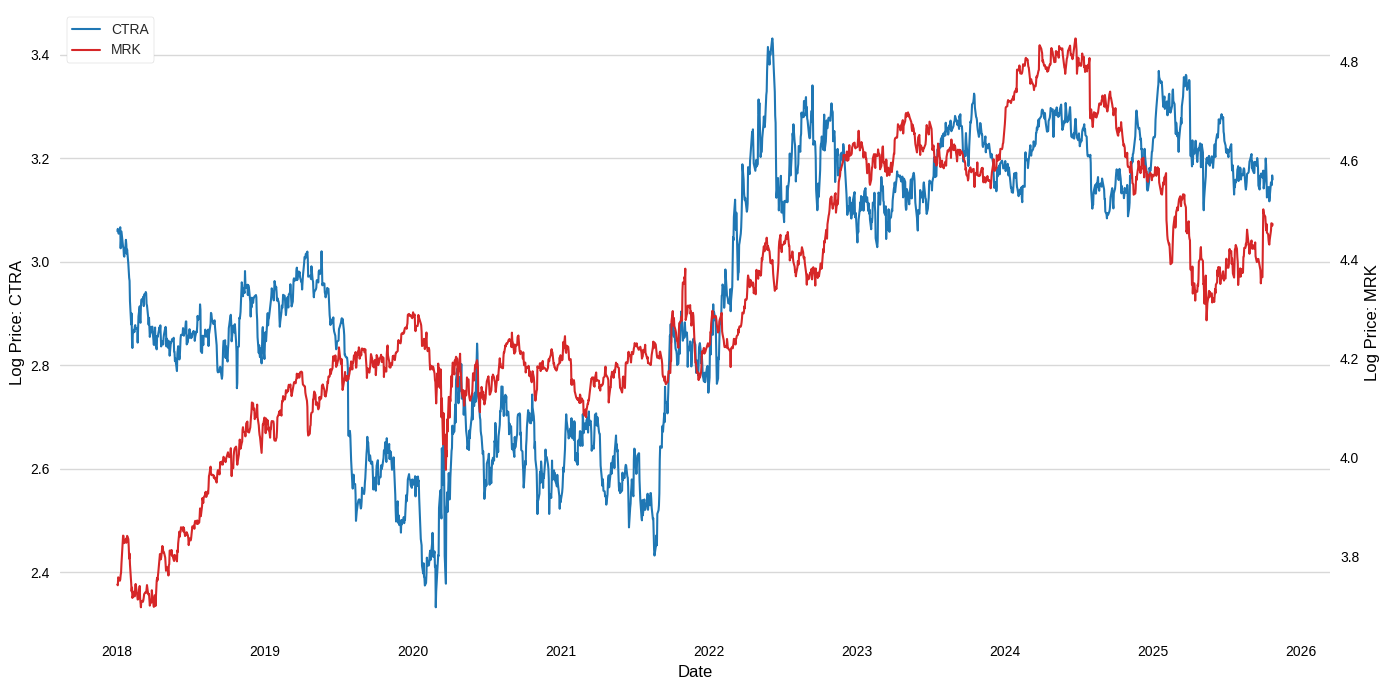

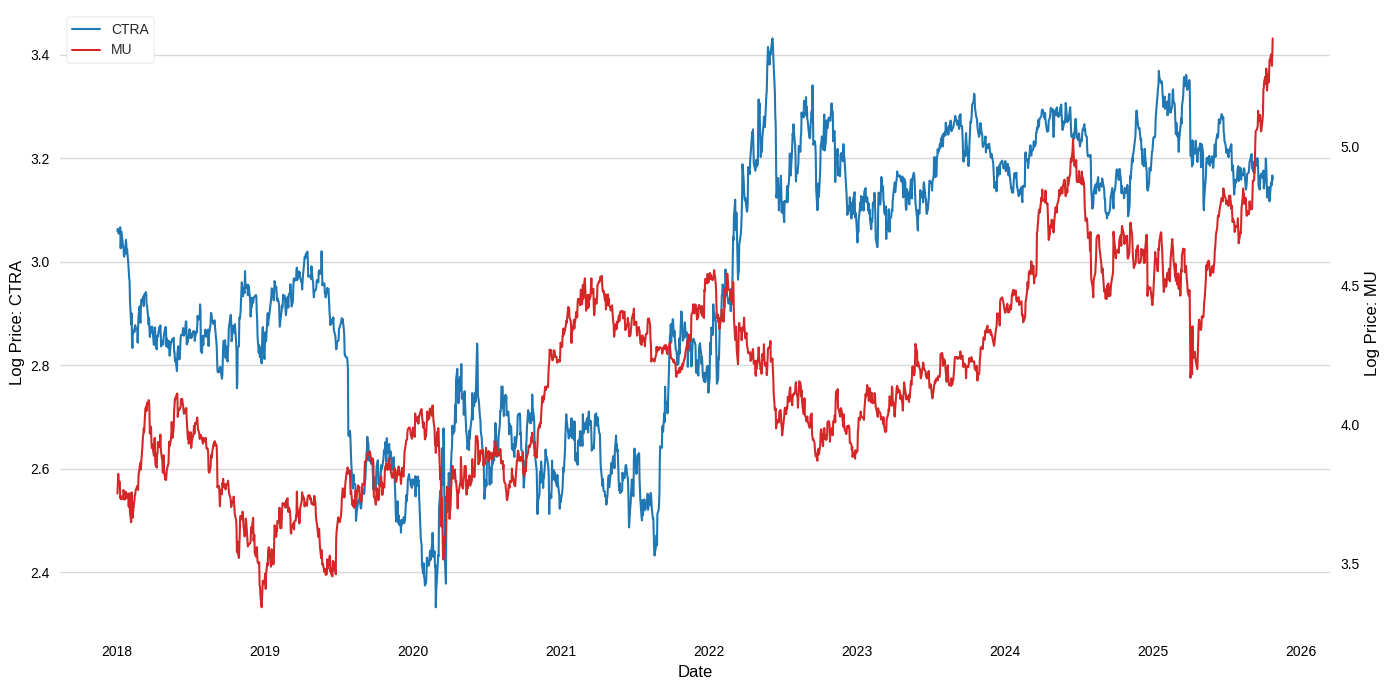

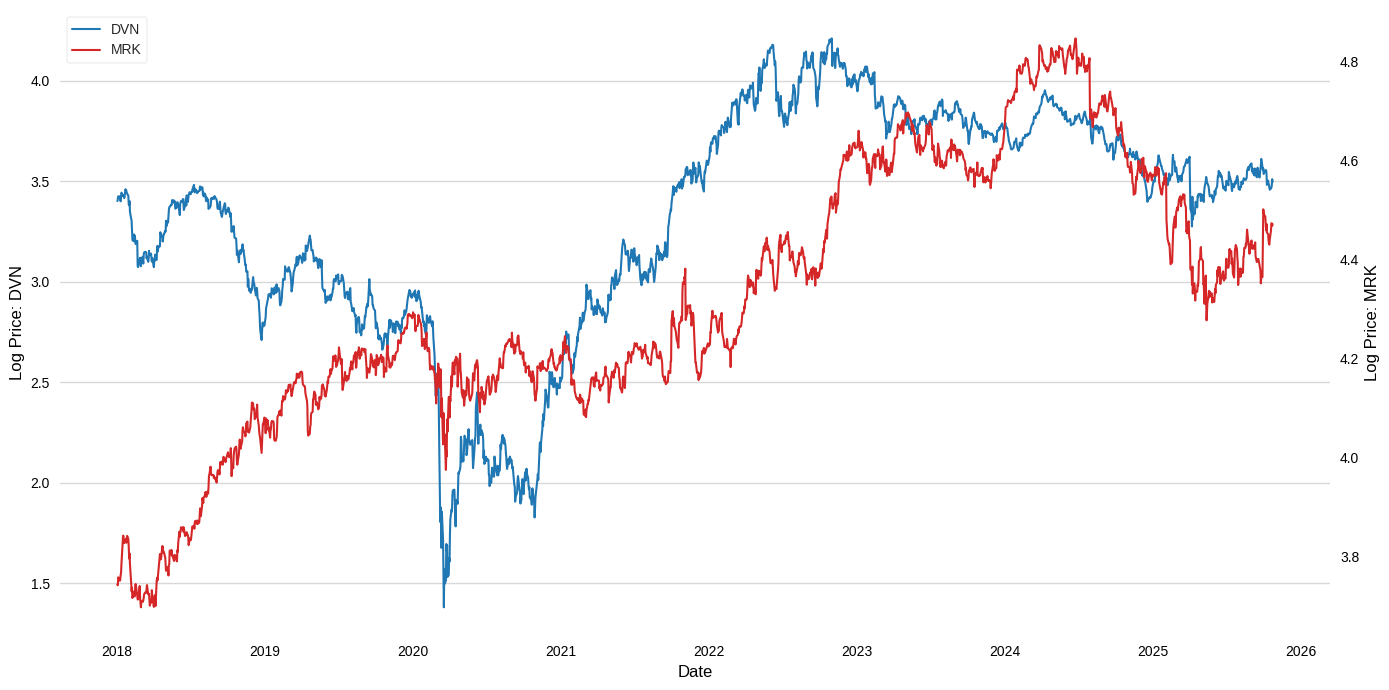

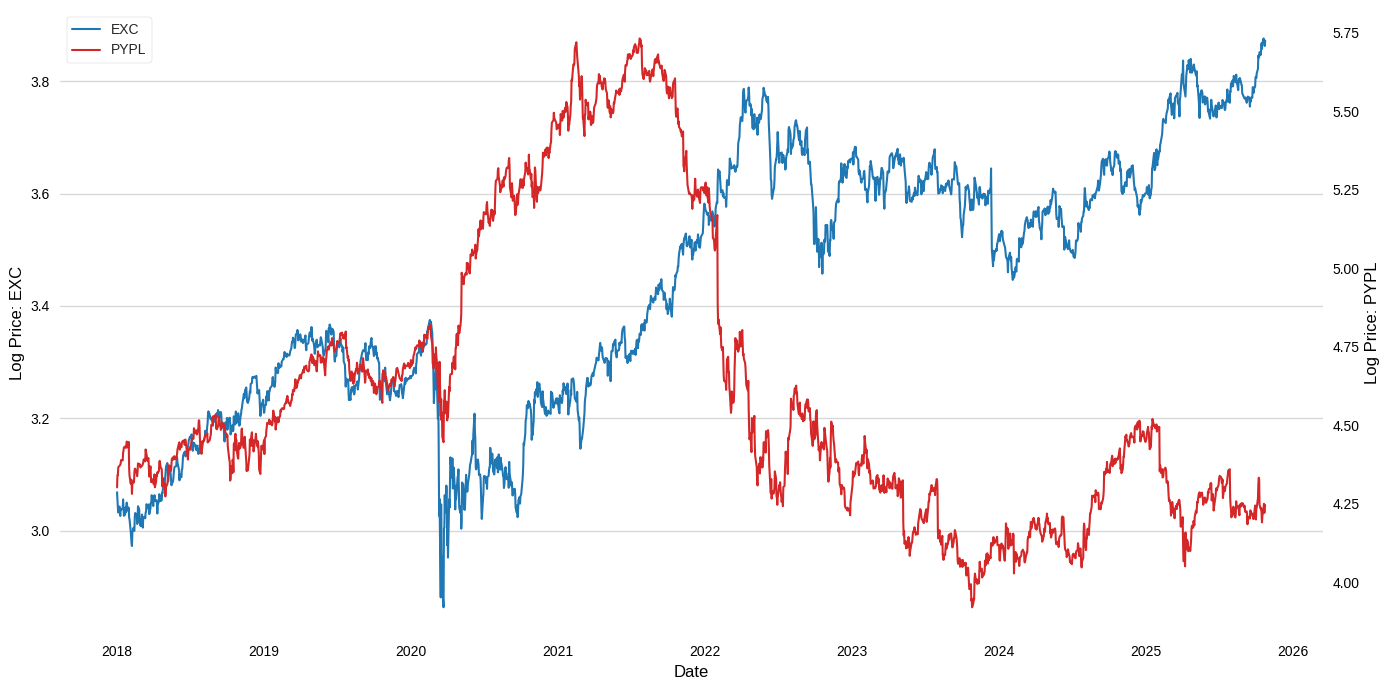

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame with 'ticker', 'date', and price columns

# --- 1. Price Column & Log Price Calculation ---
price_col = 'adj_close' if 'adj_close' in df.columns else 'close'
print(f"Using column '{price_col}' for log calculation.")

df['log_price'] = np.log(df[price_col])

# --- 2. Define Pairs to Compare ---
pairs_to_compare = [('CTRA', 'MRK'), ('CTRA', 'MU'), ('DVN', 'MRK'), ('EXC', 'PYPL')]

# --- 3. Plotting Function ---
def plot_log_pairs(data_df, pairs):
    # Set base style
    plt.style.use('seaborn-v0_8')

    for t1, t2 in pairs:
        # Filter data for each ticker
        df1 = data_df[data_df['ticker'] == t1].sort_values('date')
        df2 = data_df[data_df['ticker'] == t2].sort_values('date')

        if df1.empty or df2.empty:
            print(f"⚠️ Warning: Missing data for {t1} or {t2}. Skipping.")
            continue

        # Create figure and axis
        fig, ax1 = plt.subplots(figsize=(14, 7))

        # --- STYLE: Force White Background ---
        fig.patch.set_facecolor('white')
        ax1.set_facecolor('white')

        # --- STYLE: Very Light Horizontal Lines ---
        # axis='y': horizontal lines only
        # alpha=0.3: very transparent/light
        ax1.grid(True, axis='y', linestyle='-', color='gray', alpha=0.3)
        # Turn off vertical grid lines if you only want levels
        ax1.grid(False, axis='x')

        # Plot Ticker 1 (Left Axis)
        color1 = 'tab:blue'
        ax1.set_xlabel('Date', fontsize=12, color='black')
        ax1.set_ylabel(f'Log Price: {t1}', color='black', fontsize=12)

        l1 = ax1.plot(df1['date'], df1['log_price'], color=color1, linewidth=1.5, label=t1)

        # Set ticks to black
        ax1.tick_params(axis='x', colors='black')
        ax1.tick_params(axis='y', labelcolor='black', color='black')

        # Plot Ticker 2 (Right Axis)
        ax2 = ax1.twinx()
        color2 = 'tab:red'
        ax2.set_ylabel(f'Log Price: {t2}', color='black', fontsize=12)

        l2 = ax2.plot(df2['date'], df2['log_price'], color=color2, linewidth=1.5, label=t2)

        # Set ticks to black
        ax2.tick_params(axis='y', labelcolor='black', color='black')
        ax2.grid(False) # Ensure right axis doesn't draw conflicting grid lines

        # --- STYLE: Unified Legend ---
        lines = l1 + l2
        labels = [l.get_label() for l in lines]
        ax1.legend(lines, labels, loc='upper left', facecolor='white', framealpha=1, frameon=True)

        # Title and Formatting
        plt.title("")
        fig.tight_layout()

        # Show Plot
        plt.show()

# Run the plotting
plot_log_pairs(df, pairs_to_compare)